# Building a Movie Recommender - Part 1

## An Introduction to Collaborative Filtering

Collaborative filtering is a technique used by recommendation engines to recommend items to users, e.g. products on Amazon and movies/series on Netflix.

![](/rec-nf.png)

*Recommendations from Netflix based on my viewing history*

The basic idea behind collaborative filtering is the following:

1. Consider the items that the current user has liked
2. Find other users that have liked similar items
3. Recommend items those users have liked

In this 3-part series of posts, we will create our own movie recommendation system:

1. Part 1 (this post) - we will train a model capable of recommending movies to users
2. [Part 2](https://ravimashru.dev/blog/2021-08-24-movie-recommender-part-2/) - we will build a system to recommend movies to new users
3. Part 3 - we will create an API and UI for our system and deploy them

## The MovieLens Dataset

The MovieLens dataset contains millions of ratings of movies. For simplicity, we'll use a subset of this dataset that contains 100,000 ratings to build a model.
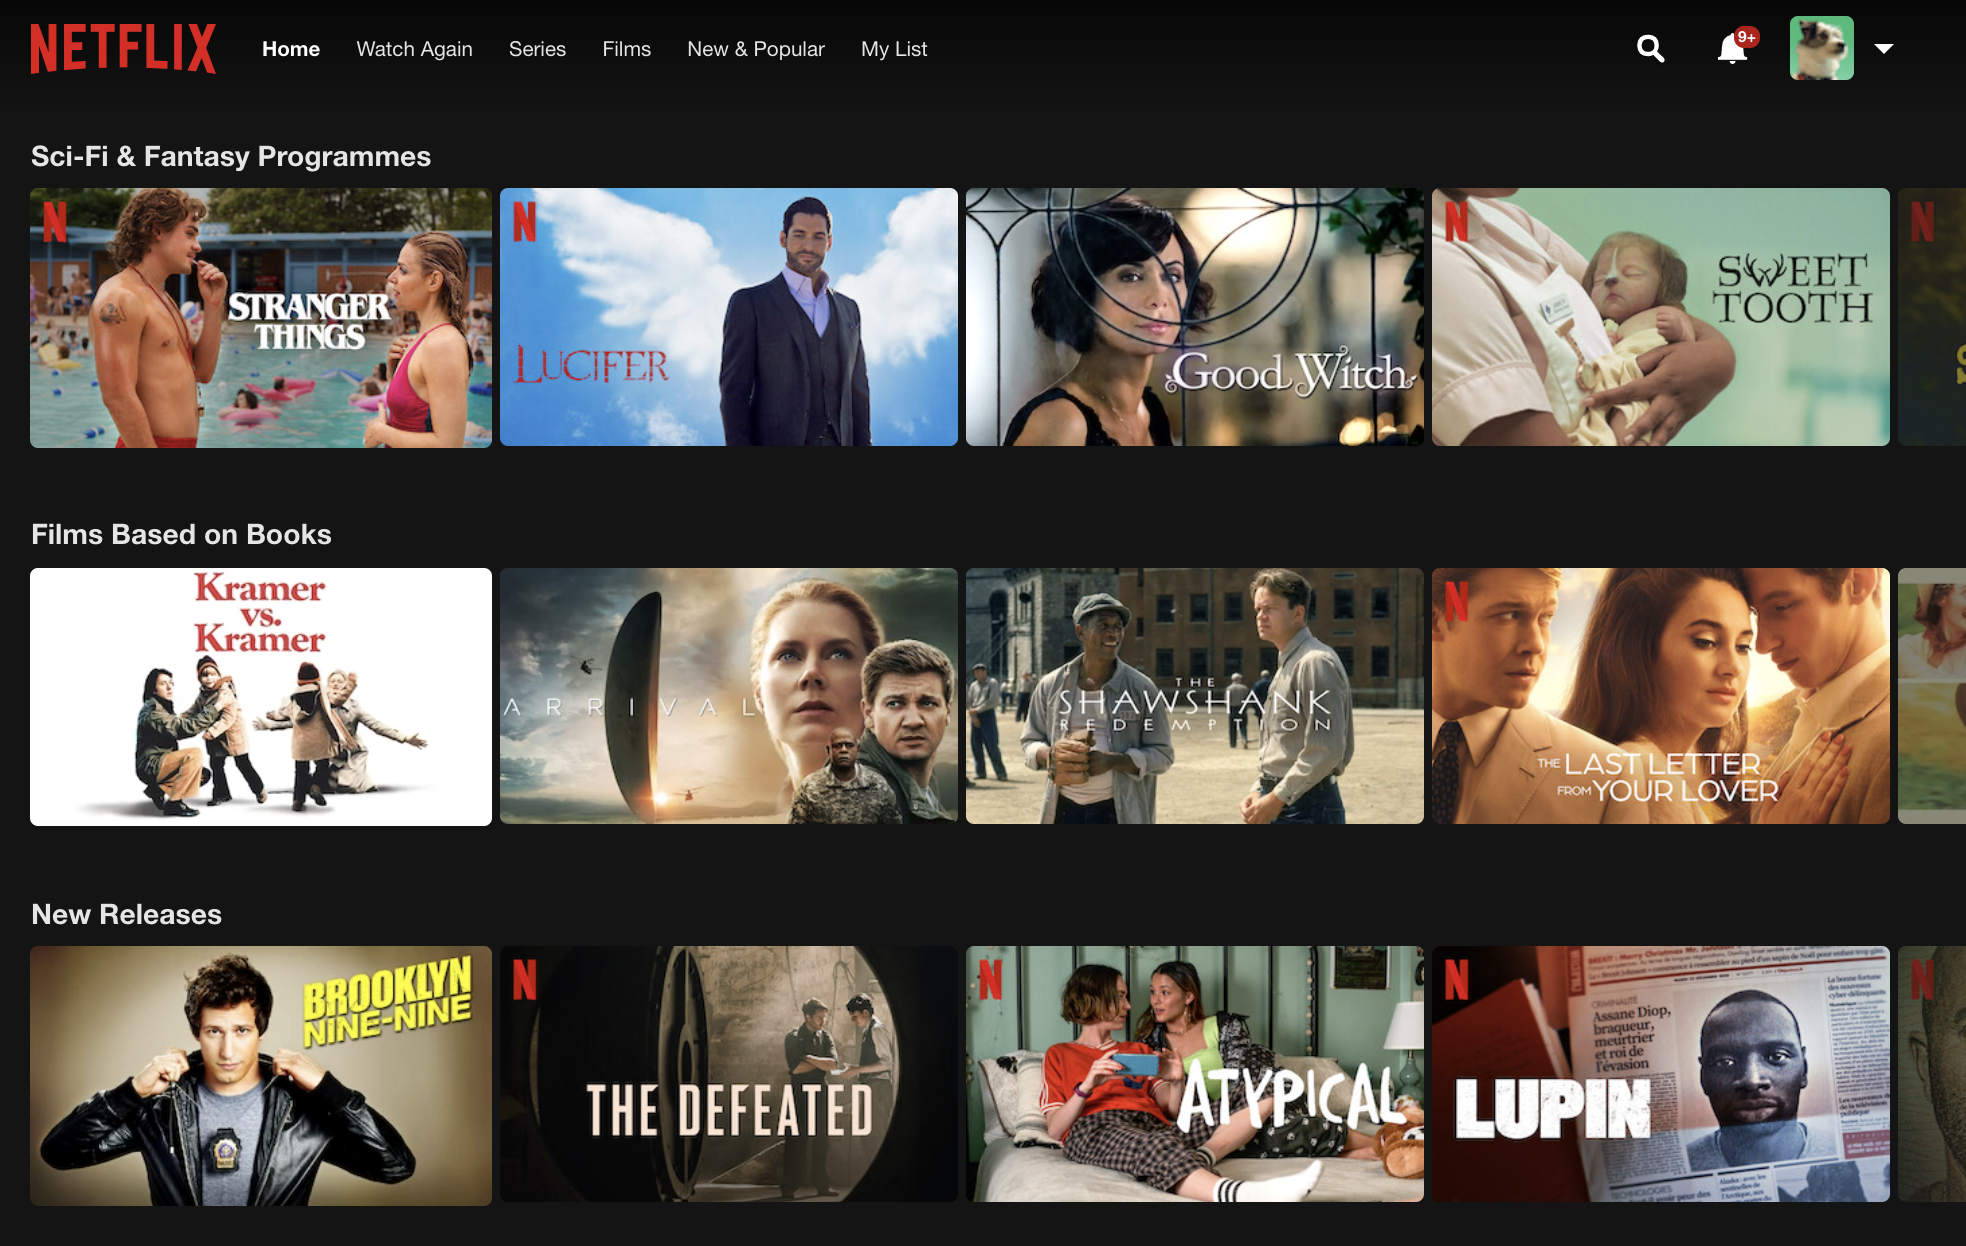

In [1]:
from fastai.tabular.all import *
path = untar_data(URLs.ML_100k)

ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None, names=['user','movie','rating','timestamp'])
ratings.head()

user  movie  rating  timestamp
0   196    242       3  881250949
1   186    302       3  891717742
2    22    377       1  878887116
3   244     51       2  880606923
4   166    346       1  886397596

Each row in this dataset is the rating a user has given to a particular movie. We need to build a model that will predict the rating a user will give to a movie they haven't watched.

Another way to view this data is by cross-tabulating it - making a table where the rows represent users and columns represent movies.

In [12]:
pd.crosstab(ratings.user, ratings.movie, values=ratings.rating, aggfunc='sum')

movie  1     2     3     4     5     6     7     8     9     10    ...  1673  \
user                                                               ...         
1       5.0   3.0   4.0   3.0   3.0   5.0   4.0   1.0   5.0   3.0  ...   NaN   
2       4.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   2.0  ...   NaN   
3       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
4       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
5       4.0   3.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
939     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   5.0   NaN  ...   NaN   
940     NaN   NaN   NaN   2.0   NaN   NaN   4.0   5.0   3.0   NaN  ...   NaN   
941     5.0   NaN   NaN   NaN   NaN   NaN   4.0   NaN   NaN   NaN  ...   NaN   
942     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
943     NaN   5.0   NaN   NaN   NaN   NaN   NaN   NaN   3.0   NaN  ...   NaN   

movie  1674  1675  1676  1677  1678  1679  1680  1681  1682  
user                                                         
1       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
3       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
4       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
5       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
...     ...   ...   ...   ...   ...   ...   ...   ...   ...  
939     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
940     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
941     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
942     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
943     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  

[943 rows x 1682 columns]

In this view of the data, we need to predict all the missing values (shown as `NaN`).

If we had properties to describe each movie, for example the genre and we also knew how much each user liked each genre, our job would be very easy. We could just recommend movies that the user hasn't watched but would like because of their genre preference.

![](/rec-user-movie.png)

However, we don't have this kind of information about the movies or users. The only thing we know is how much each user liked the movies they rated.

What we can do is create vectors (with randomly initialized values) for each user and movie. Then, instead of trying to determine what each component of the vector means, we can then use the data available to use to **learn** what the values of these vectors should be using **[gradient descent](https://ravimashru.dev/blog/2021-07-12-fastbook-ch4-part2/)**.

Such vectors are also commonly known as **latent factors** or **embeddings**.
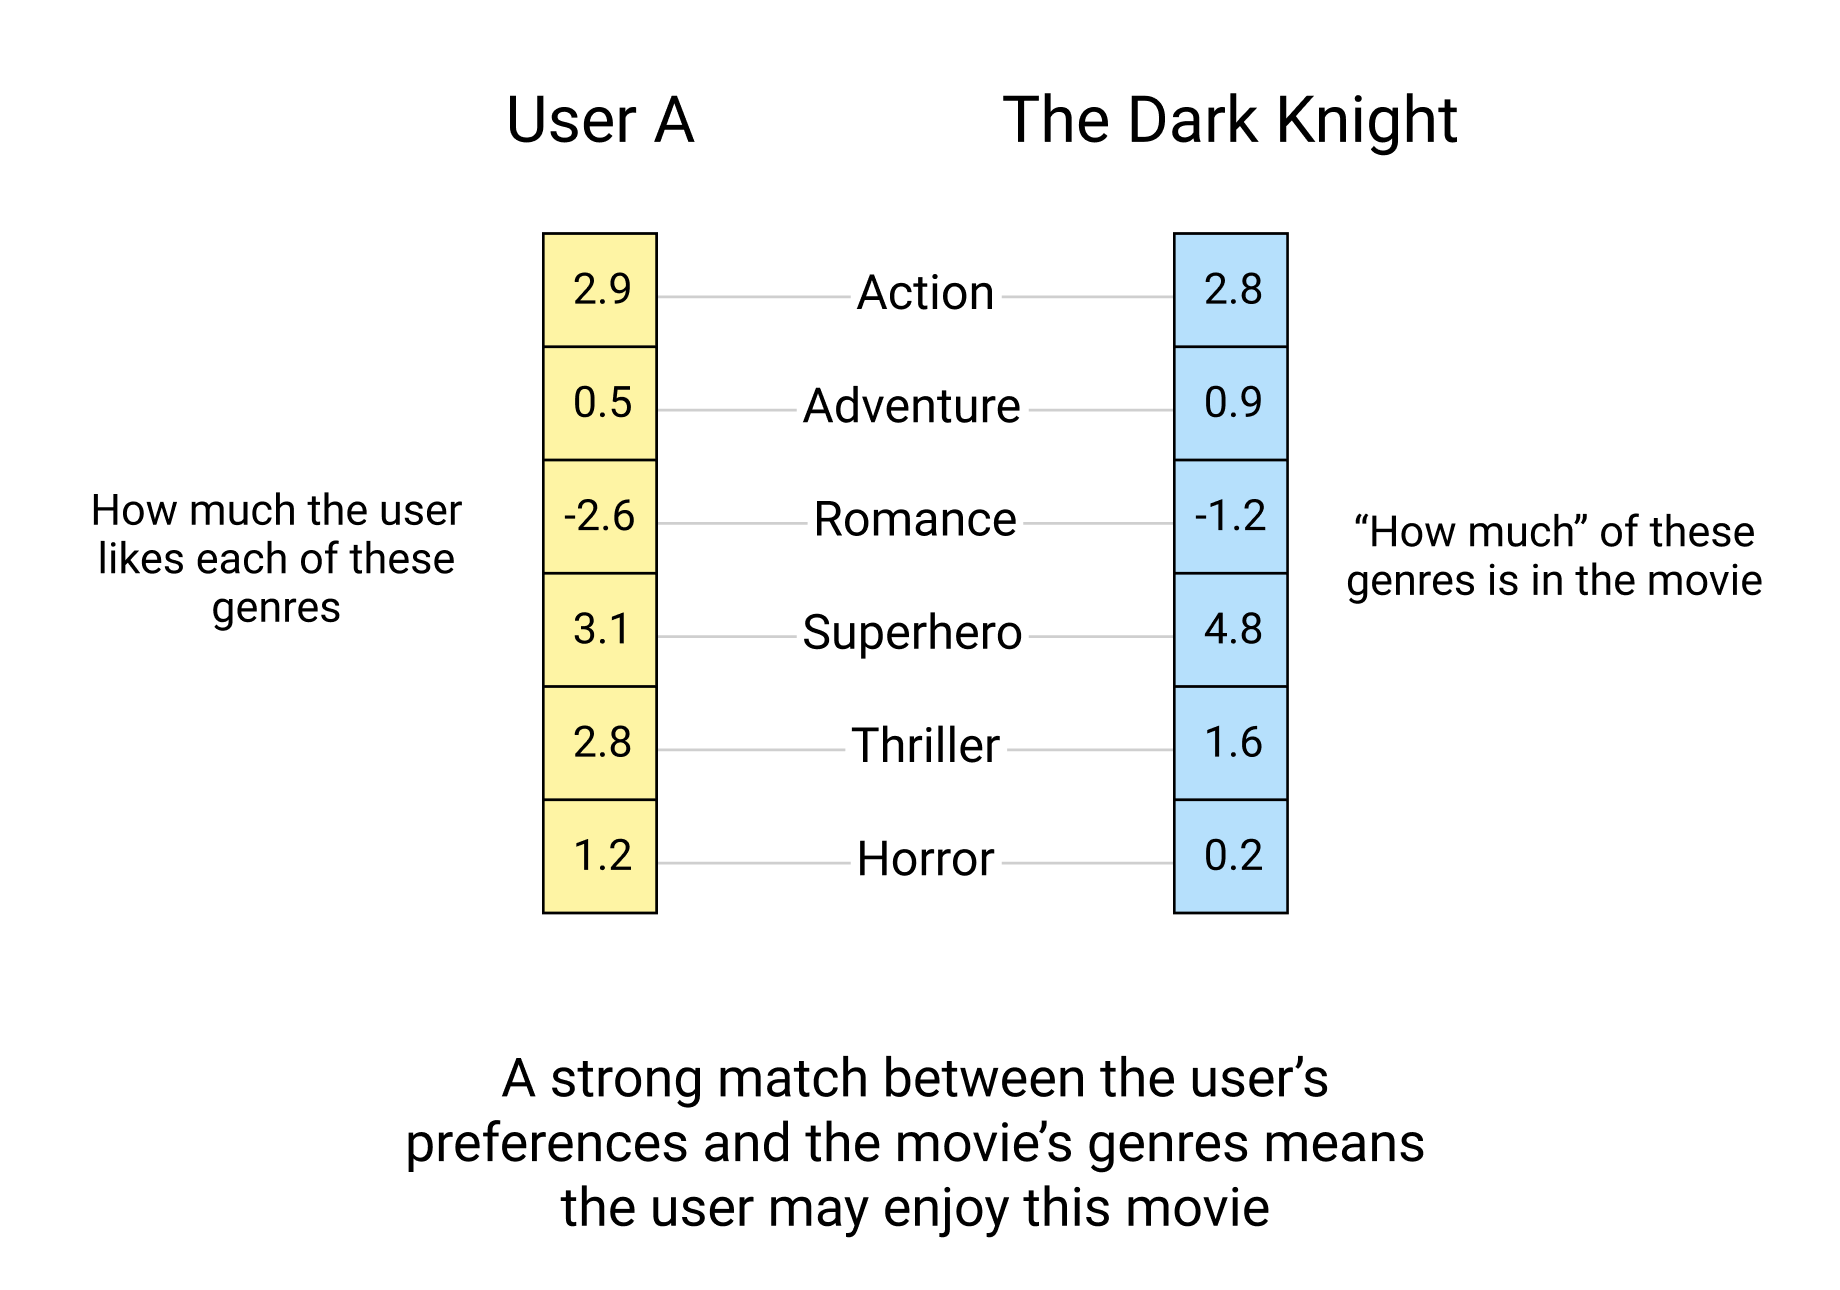

## Learning representations of movies and users

In general, gradient descent works as follows:

**Step 1: Initialize parameters**

In this case, the vectors for our users and movies are the parameters that we initialize with random values.

**Step 2: Calculate predictions**

We need to predict the rating a user gives to a movie they have watched. A straightforward way to calculate these predictions from the user and movie vectors is using the dot product.

This requires the vectors that represent users and movies to be of the same size. It is possible to use vectors of a different length for movies and a different length for users if we use a neural network instead of a dot product. We will look at this approach later in this post.

**Step 3: Calculate the loss**

The value of the loss tells us how far away our model's predictions are from the actual ratings provided by the user. Typically, a high loss value is bad and the objective of the gradient descent process is the iteratively minimize the loss value.

This difference between the actual rating value and the model's prediction is also known as the mean absolute error. Another way to calculate the loss would be using the mean squared error.

**Step 4: Optimize parameters**

The final step in the process is to update the user and movie vectors such that the loss is minimized.

![](/rec-gd.png)

## Building a model

Building a collaborative filtering model using the fastai library is extremely easy using the `fastai.collab` module.

But first, let us add names of the movies to our data so that since they are easier to understand compared to the IDs.
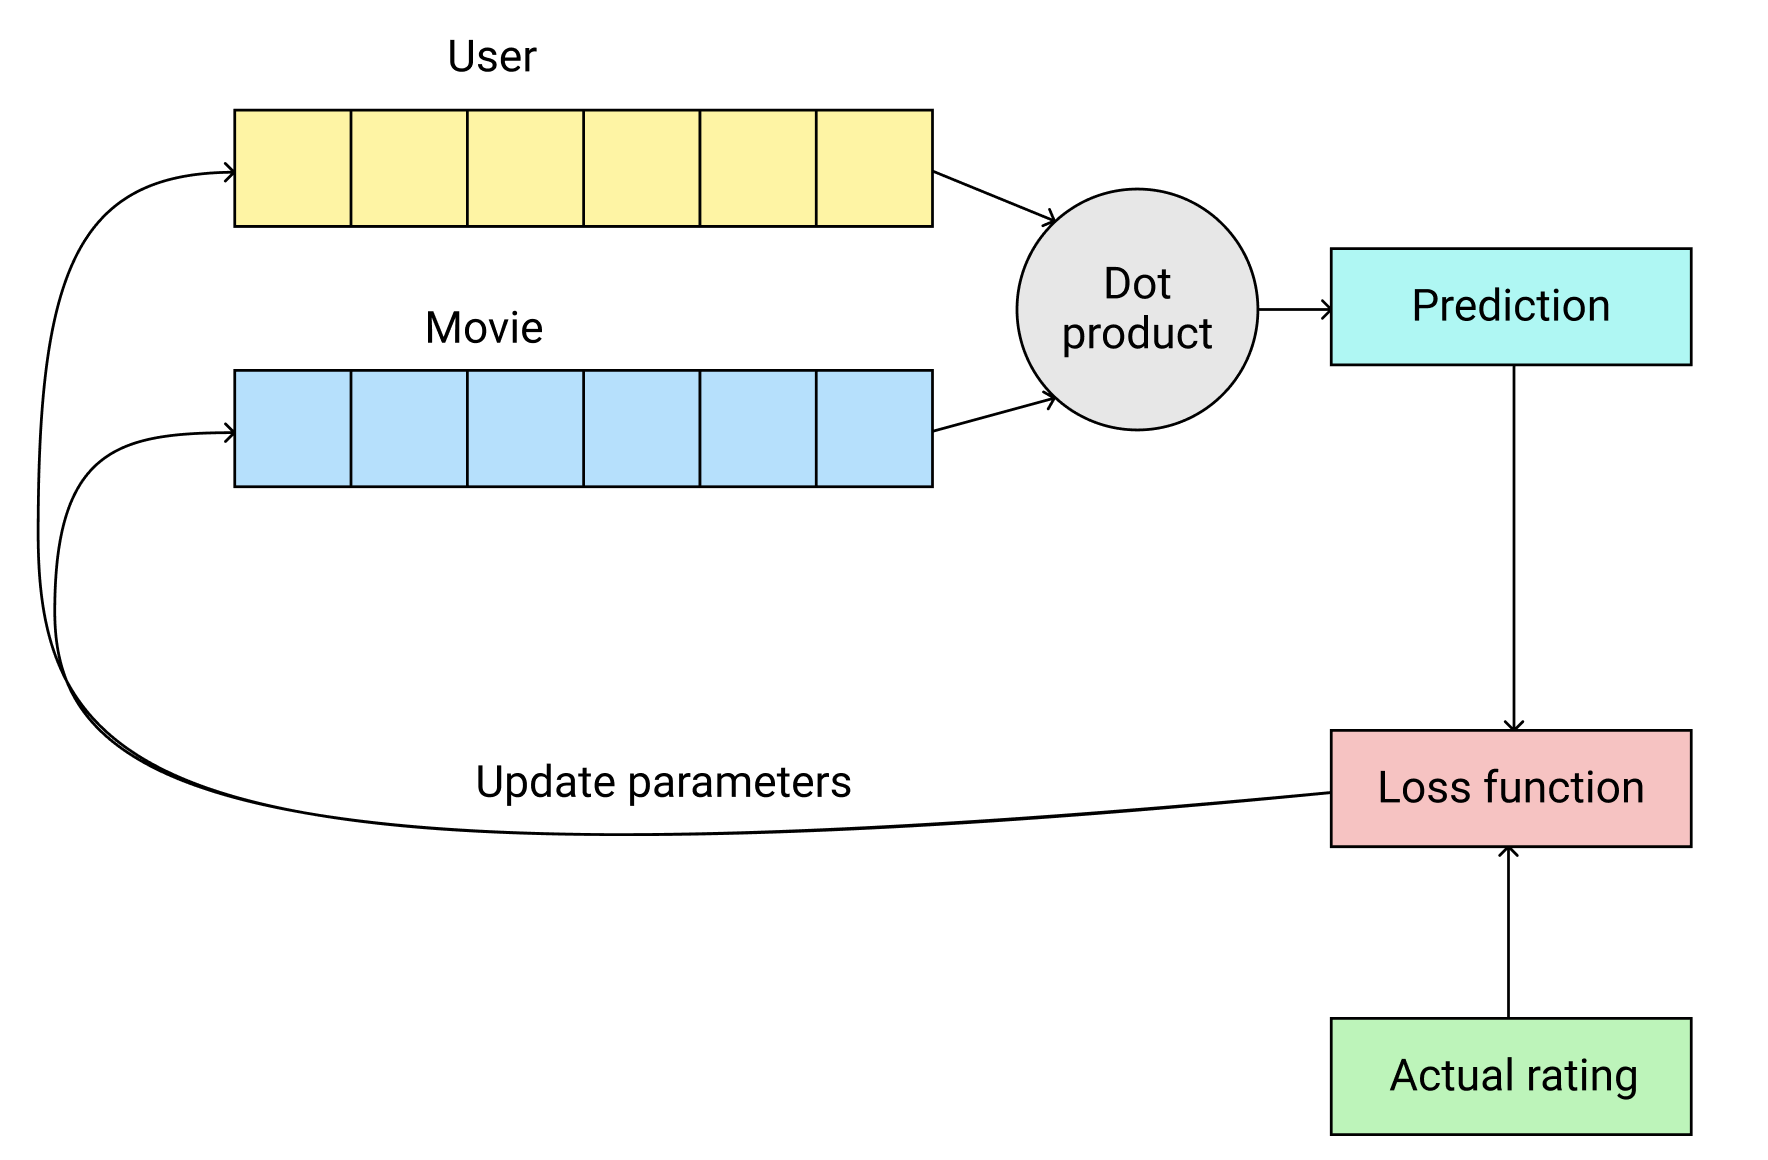

In [13]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                         usecols=(0,1), names=('movie','title'), header=None)
ratings = ratings.merge(movies)
ratings.head()

user  movie  rating  timestamp         title
0   196    242       3  881250949  Kolya (1996)
1    63    242       3  875747190  Kolya (1996)
2   226    242       5  883888671  Kolya (1996)
3   154    242       3  879138235  Kolya (1996)
4   306    242       5  876503793  Kolya (1996)

Then, we need to create DataLoaders for our data.

In [16]:
from fastai.collab import *

dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.show_batch()

We now create a model using `collab_learner`.

In [23]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

In addition to the dataloaders, we specified the following information in this line:

1. A 50-dimensional vector should be used to represent each movie and user.

2. The output of the model should be between 0 and 5.5. Although the ratings in our dataset go from 0 to 5, using a slightly higher upper bound seems to work a little better practically, according to Fastbook.


We now use the `fit_one_cycle` method to train the model.

In [24]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

We can now `export` this model so that we can use it to make predictions.

In [25]:
learn.export('movie-recommender.pkl')

[Chapter 8 of Fastbook](https://github.com/fastai/fastbook/blob/master/08_collab.ipynb) is an excellent resource to understand how this model works under the hood and how to build such a model from scratch.

## Using deep learning for collaborative filtering

The approach that we've considered so far (using the dot product between movie and user vectors to predict a user's rating) is also known as **probabilistic matrix factorization (PMF)**.

Another approach would be to use a neural network. As mentioned previously, when using neural networks the size of the user and movie vectors can be different.

Fastai provides the `get_emb_sz` function that uses some heuristics to suggest the length of vectors that can be used.

In [26]:
get_emb_sz(dls)

[(944, 74), (1665, 102)]

The recommendation for our dataset is to use:

- A vector of length 74 for each user
- A vector of length 102 for each movie

The reason these vectors don't need to be of the same length is that we concatenate the 

![](/rec-nn.png)

Using neural networks for collaborative filtering in Fastai is super-easy! We still use `collab_learner` like before, but we set `use_nn=True`. We can also specify the size of the `layers` in the network.
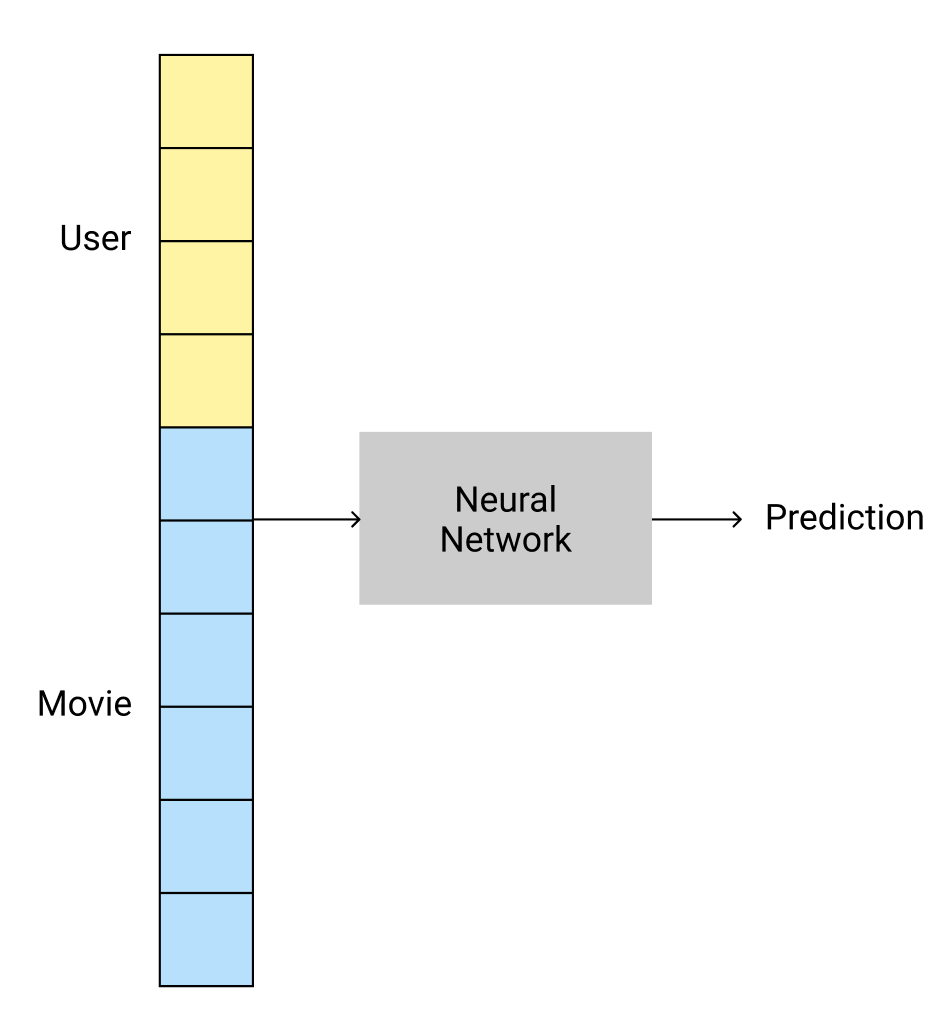

In [28]:
learn = collab_learner(dls, use_nn=True, y_range=(0, 5.5), layers=[100,50])
learn.fit_one_cycle(5, 5e-3, wd=0.1)

This approach allows us to include more information that may be relevant to make predictions (e.g. date and time of rating). All we need to do is concatenate that information to the input vector and train the neural network!

![](/rec-nn-extra.png)

## Next steps

In this post, we covered the following:

- How collaborative filtering works
- How we can use gradient descent to learn user and movie vectors
- How to use fastai to train a movie recommendation model
- How to use neural networks for collaborative filtering

In the [next post](https://ravimashru.dev/blog/2021-08-24-movie-recommender-part-2/), we'll use the model we've trained to recommend movies to new users.
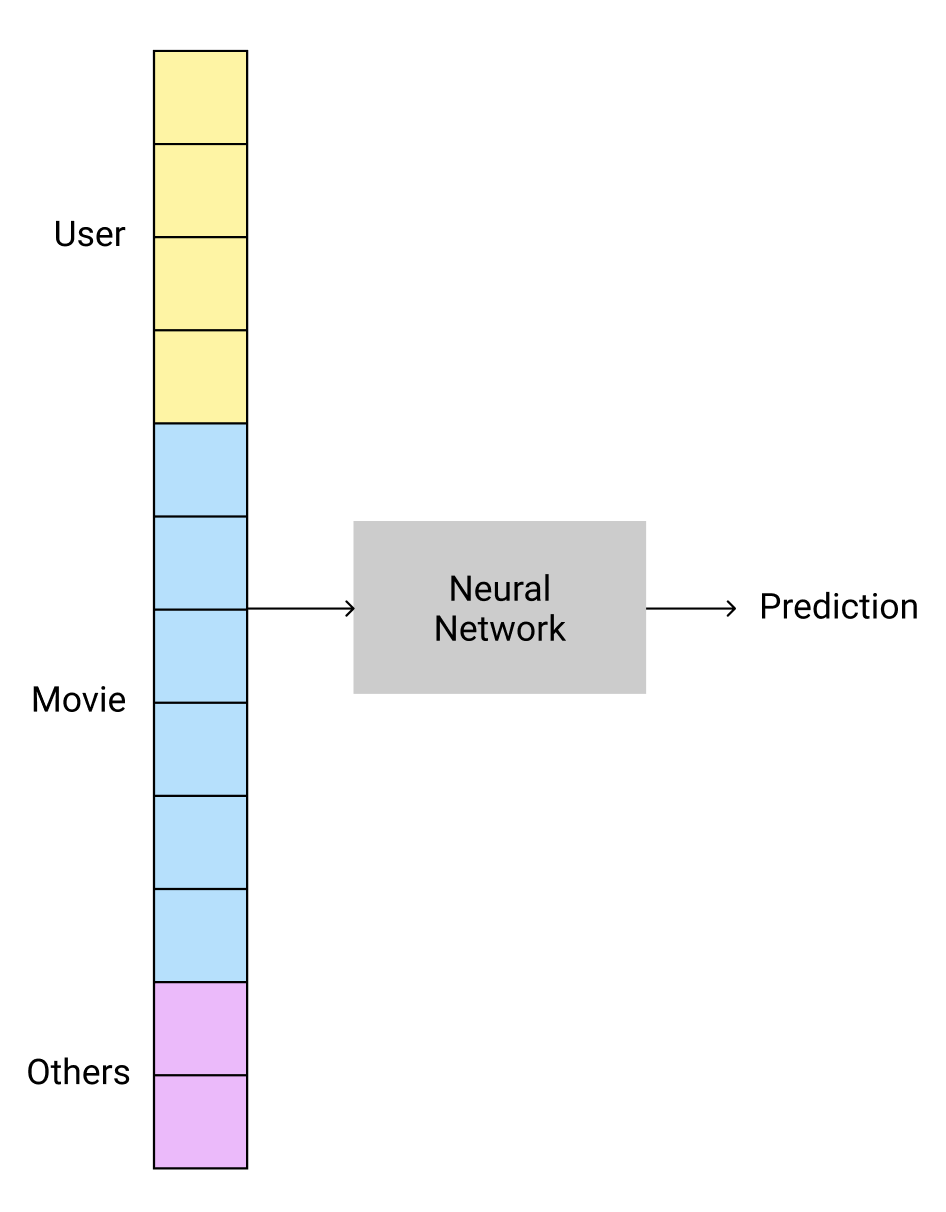